# Overview

In this tutorial we will introduce key concepts related to creating simple neural networks including a linear (single-layer) classifier as well as a multilayer perceptron.

**Linear Classifiers and Multilayer Perceptrons**

* matrix multiplication
* softmax cross-entroy loss
* model training
* evaluation
* visualization

This tutorial is part of the class **Introduction to Deep Learning for Medical Imaging** at University of California Irvine (CS190); more information can be found at: https://github.com/peterchang77/dl_tutor/tree/master/cs190.

# Google Colab

### Enable GPU runtime

Use the following instructions to switch the default Colab instance into a GPU-enabled runtime:

```
Runtime > Change runtime type > Hardware accelerator > GPU
```

# Environment

### Jarvis library

In this notebook we will Jarvis, a custom Python package to facilitate data science and deep learning for healthcare. Among other things, this library will be used for low-level data management, stratification and visualization of high-dimensional medical data.

In [1]:
# --- Install jarvis (only in Google Colab or local runtime)
% pip install jarvis-md

     |████████████████████████████████| 89 kB 7.2 MB/s 
     |████████████████████████████████| 596 kB 45.2 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


### Imports

Use the following lines to import any additional needed libraries:

In [2]:
import numpy as np, pandas as pd
from tensorflow.keras import Input, Model, models, layers, losses, metrics, optimizers
from jarvis.train import datasets
from jarvis.utils.display import imshow

# Data

The data used in this tutorial will consist of the MNIST handwritten digit dataset. The custom `datasets.download(...)` method can be used to download a local copy of the dataset. By default the dataset will be archived at `/data/raw/mnist`; as needed an alternate location may be specified using `datasets.download(name=..., path=...)`. 

In [3]:
# --- Download dataset
datasets.download(name='mnist')

[ 2022-04-07 20:20:15 ] [====================] 100.000% : Extracting archive (0000004 / 0000004) 

{'code': '/data/raw/mnist', 'data': '/data/raw/mnist'}

Once downloaded, the `datasets.prepare(...)` method can be used to generate the required python Generators to iterate through the dataset, as well as a `client` object for any needed advanced functionality.

In [4]:
# --- Prepare generators
gen_train, _, client = datasets.prepare(name='mnist', custom_layers=True)

[ 2022-04-07 20:20:16 ] [====================] 100.000% : Iterating | 000001    

By default the generator for this dataset yields a batch size of 128 different images. As before, each iteration yields dictionary of model inputs, `xs`. In the current example, there is just a single input image `xs['dat']` and a single target `xs['digit']`. Let us examine the generator data:

In [5]:
# --- Yield one example
xs, _ = next(gen_train)

# --- Print dict keys
for k, v in xs.items():
    print('key = {} : shape = {}'.format(k.ljust(7), v.shape))

key = dat     : shape = (128, 784)
key = digit   : shape = (128, 1)


Each 28 x 28 2D image is serialized as a 784-element vector. Use the following lines of code to reshape the data vector and visualize using the `imshow(...)` method:

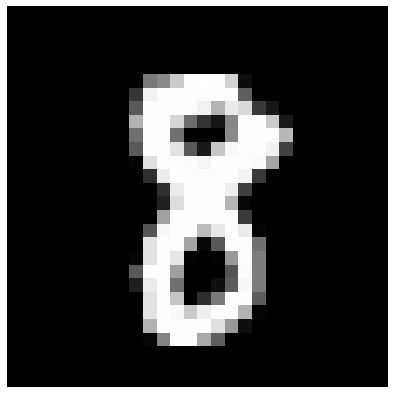

In [6]:
# --- Reshape to 2D images
dat = xs['dat'].reshape(-1, 28, 28)

# --- Show the first example
imshow(dat[0])

In [7]:
dat.shape

(128, 28, 28)

Pass the entire dat array to `imshow(...)` to display an N x N mosaic of all images:

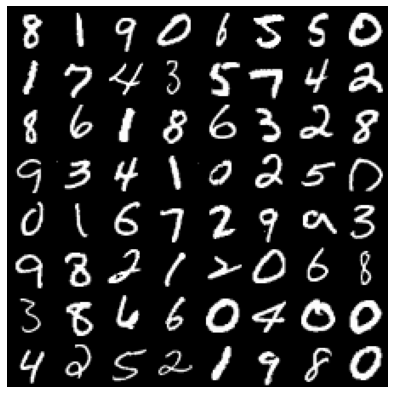

In [8]:
# --- Show "montage" of first 64 images
imshow(dat[:64])

As expected, the 64-element `xs['digit']` vector corresponds to ground-truth:

In [9]:
# --- Print xs['digit']
print(xs['digit'][:64].reshape(8, 8))

[[8 1 9 0 6 5 5 0]
 [1 7 4 3 5 7 4 2]
 [8 6 1 8 6 3 2 8]
 [9 3 4 1 0 2 5 0]
 [0 1 6 7 2 9 9 3]
 [9 8 2 1 2 0 6 8]
 [3 8 6 6 0 4 0 0]
 [4 2 5 2 1 9 8 0]]


# Foundations

As a review, recall the diagramatic representation of a neural network covered in lecture:

![Diagramtric Representation](https://raw.githubusercontent.com/peterchang77/dl_tutor/master/cs190/spring_2020/notebooks/mlp/pngs/nn_diagram.png)

Recall that each reach "retinal neuron" recieving light from the image is connected to one of ten output neurons, each indicating the relative likelihood of that image representing any one of the ten possible digits. The neuron with the largest score value (e.g. **logit score**) in turn represents the most probable interpretation by the network of the provided digit image.

Also, recall that each connection itself is modeled by a multiplicative weight value that represents how strong (or weak) the connection is, and that each of the 784 connections to one of our ten output neurons can in fact be represented as a matrix of numbers:

![Matrix Representation](https://raw.githubusercontent.com/peterchang77/dl_tutor/master/cs190/spring_2020/notebooks/mlp/pngs/nn_multiply.png)

For each of our ten digits, we will have a different 28 x 28 weight matrix for a total of 10 weight matrices. Finally keep in mind that although our images are represented as 28 x 28 matrices in these diagrams, our input image for model training will be flattened into a 1 x 784 vector a single matrix multiplication operation of size `(784, 10)` is used to map the input vector into 10 different logit scores.  

# Matrix Multiplication

### Input

The input matrix will need to accomodate a **flattened** version of our 28 x 28 matrix:

```
x = [[x00, x01, x02, ...],   ==> (flattening) ==> [[x00, x01, x02, x10, x11, ..., xNN]]
     [x10, x11, x12, ...],
     [x20, x21, x22, ...]
     ... , ..., ..., xNN]]
```

Thus our input matrix will need to be  of size `28 x 28 = 784`.  Use the following code cell to create our `Input(...)` object:

In [10]:
# --- Create Tensorflow input
x = Input(shape=(784,))
print(x.shape)

(None, 784)


### Dense operation

The next step is to define the proper matrix multiplication operation to implement mapping of input (image) to output (digit logit scores). Recall the earlier discussion on **dense** layers and matrix multiplication:

```
Let:

X = 1 x N matrix = [a, b, c, d, e...]

M = N x 1 matrix = [[A],
                    [B],
                    [C],
                    [D],
                    [E],
                    ...
                    ]

Then:

X x M = ...

= [[a, b, c, d, e...]] x [[A], = a * A + b * B + c * C + d * D + e * E ...
                          [B],
                          [C],
                          [D],
                          [E],
                          ...
                          ]
                          
```

The following rules extend this formally to 2D matrices.

```
Let:

X = I x N matrix
M = N x J matrix
```

1. The **second** dimension of `X` must match the **first** dimension of `M` (e.g. `N`).
2. The output of the matrix multiplication is equal to the **first** dimension of `X` by the **second** dimension of `Y` (e.g. `I x J`).

Given the discussion above, in order to define a *matrix multiplication* between the input Tensor and the `m` weights matrix, what shape must the `m` weights matrix consist of to yield 10 different logit score predictions?

Use the following code cell to create the appropriate operation object:

In [11]:
# --- Create op
op = layers.Dense(10)

# --- Create output
logits = op(x)
print(logits.shape)

(None, 10)


Let us check to see if the weights are of correct shape:

In [12]:
# --- Get weight matrix shape
w, b = op.get_weights()
print(w.shape)

(784, 10)


# Creating Models

## Backbone model

This single operation model successfully defines the linear classification model as presented during lecture. Let us start by creating the base `backbone` model (e.g., without training dependencies). Use the following line of code to create the `backbone` model:

In [13]:
# --- Define model
x = Input(shape=(784,))
logits = layers.Dense(10)(x)

# --- Create model
backbone = Model(inputs=x, outputs=logits)

Use the following line of code to pass a single batch of data through the created model:

In [14]:
# --- Predict
scores = backbone.predict(xs['dat'])

What is the output shape of the `scores` variable, what does this variable represent?

In [15]:
# --- Logit scores
print(scores.shape)

(128, 10)


In [29]:
scores[0]

array([ 1.6391629 ,  0.65614617, -2.1650326 ,  1.0734098 , -3.9274411 ,
       -2.2741659 ,  0.54319525, -0.85836047,  6.4782662 , -3.901466  ],
      dtype=float32)

## Training model

Next, the `backbone` model architecture is wrapped in a second model with additional layer(s) that define optimization behavior including loss function derivations. To do so, recall that the following steps are required:

1. Define a *wrapper* `Model(...)` that encapsulates our `backbone` model
2. Define loss tensors (and add to the model)
3. Define compile parameters including optimization strategy

Let us look at each of these steps in further detail.

### Inputs

As before, we start by defining all `inputs` into our new *wrapper* model. In the first model, we only defined a single `x` input because the `backbone` base model is designed to accept any input value(s) and make predictions without requiring a target. In our second *wrapper* model, specifically designed to facilitate model training, we additionally need an `Input` object for the target `digit` so that we can calculate a loss value and improve our model performance through optimization. 

In [16]:
inputs = {
    'dat': Input(shape=(784,), name='dat'),
    'digit': Input(shape=(1,), name='digit')}

Using this `inputs` Python dictionary, let us first redefine the simple linear classifier model. Importantly, as opposed to manually defining new layer operations using `layers.Dense(...)` as above, we will **reuse** the `backbone` object that we already defined. Doing so means that our new *wrapper* model is explicitly derived from the `backbone`. Any updates applied to our new *wrapper* model are propogated to the `backbone` model and vice versa. 

In [17]:
# --- Define first step of new wrapper model
logits = backbone(inputs['dat'])

### Softmax cross-entropy loss

After generating **logit** scores, one must define a method to: (1) convert logit scores to final prediction; (2) quantify the *goodness* of model prediction. These steps are performed mathematically with what is known as a loss function. For classification problems, the standard function to use is the **softmax cross-entropy** loss. This loss in fact is composed of two seperate steps:

* **softmax**: method to normalize logit scores into a probability distribution
* **cross-entropy**: method to quantify difference between predicted distribution and true distribution

To define a softmax cross-entropy loss in Tensorflow, use the `losses.SparseCategoricalCrossentropy(...)` class. The sparse formulation is a special case of cross-entropy loss where only a single mutually exclusive class is correct for any given input. The `from_logits=True` argument is used to denote that raw logit scores are passed as input and that a softmax normalization is required before calculating cross-entropy loss. It is recommended to perform these two steps simultaneously rather than split into two seperate operations for numeric stability.

In [18]:
# --- Define a loss object
sce = losses.SparseCategoricalCrossentropy(from_logits=True)

The returned variable `sce` is a Python method that can be used to calculate softmax cross-entropy loss for a given set of logit scores (`y_pred`) and ground-truth (`y_true`). For demonstration, use the following lines of code to calculate the loss for the generate logit scores of the current data batch:

In [35]:
sce?

In [19]:
# --- Calculate loss
sce(y_true=xs['digit'], y_pred=scores)

<tf.Tensor: shape=(), dtype=float32, numpy=6.7544994>

As training proceeds, the goal of the algorithm is to update weights in a manner such that this loss value decreases over time.

The `scores` variable represents the logit scores for one batch of input data. However, we still need to define a symbolic TensorFlow tensor as a part of our graph. Let us formally create this loss tensor now using the `sce` function using the `logits` returned by the `backbone` call earlier.

In [20]:
# --- Create loss tensor
loss = sce(y_true=inputs['digit'], y_pred=logits)

### Accuracy metric

Compared to *loss* values which the model will directly optimize, a *metric* is a quantitative value that captures a more human-interpretable value for overall model performance. Because the metric does not contribute to the optimization process (only used to monitor performance), this value **does not** need to be differentiable.

For a classification problem, the most common metric is overall *accuracy*. Use the TensorFlow built-in method `metrics.sparse_categorical_accuracy(...)` to calculate per-batch accuracy:

In [21]:
# --- Define accuracy
acc = metrics.sparse_categorical_accuracy(y_true=inputs['digit'], y_pred=logits)

In [36]:
acc

<KerasTensor: shape=(None,) dtype=float32 (created by layer 'tf.cast_5')>

How would you calculate the accuracy manually using NumPy (or TensorFlow)?

### Create model

Now let us create the new wrapper model. The inputs are defined above already in our `inputs` Python dictionary. As outputs, let us return both the `logits` tensor as well as the `loss`. We will name this new wrapper model `training` because it will be used for training only. 

In [22]:
training = Model(inputs=inputs, outputs={'logits': logits, 'loss': loss, 'acc': acc})

Now let's add the `loss` and `metric` tensorws we defined above to the new `training` model:

In [23]:
# --- Add loss
training.add_loss(loss)

# --- Add metric
training.add_metric(acc, name='acc')

## Compiling a Model

The current model parameters have been initialized to random values. Through exposure to data, the goal is for the model to *learn* optimal parameter values that allow for robust mapping of provided input to target output. To prepare the model for learning, a graph must be **compiled** with a strategy for optimization.

In [24]:
# --- Define an Adam optimizer
optimizer = optimizers.Adam(learning_rate=1e-2)

# --- Compile model
training.compile(optimizer=optimizer)

The model is now compiled and ready for training!

# Model Training

Once the model has been compiled and the data prepared (via a generator), training can be invoked using the `model.fit(...)` method. The only parameters that need to be set relate to the number of total training iterations (total number of steps = `steps_per_epoch` x `epochs`). 

In [25]:
training.fit(
    x=gen_train, 
    steps_per_epoch=250, 
    epochs=4)

Epoch 1/4
250/250 [==============================] - 24s 96ms/step - loss: 1.0296 - acc: 0.8233
Epoch 2/4
250/250 [==============================] - 24s 96ms/step - loss: 0.5893 - acc: 0.8661
Epoch 3/4
250/250 [==============================] - 24s 96ms/step - loss: 0.5383 - acc: 0.8790
Epoch 4/4
250/250 [==============================] - 24s 97ms/step - loss: 0.5927 - acc: 0.8761


### Evaluation

To test the trained model, the following steps are required:

* load data
* use `backbone.predict(...)` or `training.predict(...)` to obtain logit scores
* use `np.argmax(...)` to obtain prediction
* compare prediction with ground-truth
* serialize in Pandas DataFrame

Recall that the generator used to train the model simply iterates through the dataset randomly. For model evaluation, the cohort must instead be loaded manually in an orderly way. For this tutorial, use the `client.get(rows=...)` method. Since there is no special train or valid split currently, simply load all 60,000 examples:

In [26]:
# --- Load all data
arrs = client.get(rows=np.arange(60000))

Use the following lines of code to run prediction:

In [27]:
# --- Predict
outputs = training.predict(arrs['xs'])

# --- Argmax
pred = np.argmax(outputs['logits'], axis=1)

In [42]:
np.argmax(outputs['logits'], axis=1)

array([5, 0, 4, ..., 5, 5, 8])

Prepare results in Pandas DataFrame for ease of analysis and sharing:

In [28]:
df = pd.DataFrame(index=np.arange(60000))

# --- Define columns
df['true'] = arrs['xs']['digit'][:, 0]
df['pred'] = pred
df['corr'] = df['true'] == df['pred']

# --- Print accuracy
print(df['corr'].mean())

0.8646833333333334


How does this compare to the `accuracy` calculated by `training.predict(...)`?

In [41]:
outputs['acc'].mean()

0.86468333

# Visualization

What are the expected weights learned by the model? Use the following lines of code to visualize:

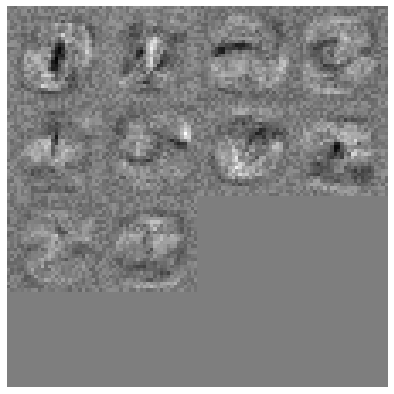

In [30]:
# --- Get weights of first layer
weights = backbone.layers[1].get_weights()[0]

# --- Show
imshow(weights.T.reshape(-1, 28, 28))

## Saving and Loading a Model

After a model has been successfully trained, it can be saved and/or loaded by simply using the `backbone.save()` and `backbone.load_model()` methods. 

In [31]:
# --- Serialize a model
backbone.save('./mlp.hdf5')

In [32]:
# --- Load a serialized model
del backbone
backbone = models.load_model('./mlp.hdf5', compile=False)

# Exercises

The following exercise questions will assist in preparation for this lesson's assignment, to extend our single-layer linear classifier into a multilayer perceptron.

### Exercise 1

The key to synthesizing multiple layers is the addition of activation functions after each matrix multiplication. How do you add a **relu** activation to the `layers.Dense(...)` call? 

Use the following cell to experiment:

In [34]:
logits = layers.Dense(10, activation = 'relu')(x)

#### Hints

Use the Jupyter / iPython `?` command to see function and class initialization signatures:

In [33]:
layers.Dense?

### Exercise 2

All hidden layers require an activation function, however the last layer (e.g. the layer that yields the final logit scores) **does not**. Why is this so?

Create a single hidden layer neural network below, ensuring that the last layer does not have any activation function:

In [53]:
# --- Define hidden layer size (integer)
h0 = 784

# --- Define network
hidden = layers.Dense(h0, activation='relu')(x)
logits = layers.Dense(10)(hidden) 

#### Hints

If defined correctly, the model **logit scores** should return values that are both negative and positive. If the `ReLU` activation was accidently applied to the last layer, the logit scores should only be positive. How do we check for this?

In [54]:
# --- Create the model
backbone = Model(inputs=hidden, outputs=logits)

In [55]:
# --- Pass an example xs input into the model
xs, _ = next(gen_train)
scores = backbone.predict(xs['dat'])

# --- Print scores
print(scores)

[[-4.4933457e+00  8.2976913e-01  5.1583805e+00 ... -1.1828016e+00
  -2.9944563e+00 -2.2384133e+00]
 [ 2.7835667e-01  4.2073536e+00  4.5512400e+00 ...  9.3091822e-01
   8.0509454e-01 -5.5518824e-01]
 [-2.4866319e+00  3.2523737e+00  4.9077363e+00 ...  8.1246078e-01
  -9.3595111e-01 -1.8502915e+00]
 ...
 [-2.5873914e+00  2.3067613e+00  4.1506939e+00 ... -5.7062030e-01
   3.5978496e-01  7.9404914e-01]
 [-1.1741126e+00  3.2550535e+00  2.4086885e+00 ... -2.3000145e-01
   4.8075020e-02 -2.4174643e+00]
 [ 4.2378902e-05  2.5880356e+00  4.6263590e+00 ... -1.1322231e+00
  -1.5708516e+00  4.6488333e-01]]
